In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, uniform, kstest

In [2]:
import os
print(os.getcwd())

C:\Users\niall\OneDrive - University of Southampton\PhD


In [3]:
random_seed = 97

In [4]:
# Function: computing W and d (diagonal entries)

def A_matrix(A_dim=100, W_tilde_mean=0, W_tilde_scale=1, exp_rate=1):
    
    # IID N(W_tilde_mean, W_tilde_scale) entries
    W_tilde = np.random.normal(loc = W_tilde_mean, 
                               scale = W_tilde_scale, 
                               size = (A_dim, A_dim))
    
    # QR decomposition
    Q, R = np.linalg.qr(W_tilde)
    W = Q

    # Diagonal matrix elements (using Exp(lambda))
    exp_scale = 1/exp_rate
    d = np.random.exponential(scale=exp_scale, size=A_dim)
    
    return W, d

In [9]:
# Function: drawing solution vectors x^(i) from prior mu_0 = N(0, A^-1)

def sample_solution_x(W, d):
    
    # Inverse & squareroot of D matrix elements for transforming std. normal samples
    inv_sqrt_d = 1.0 / np.sqrt(d)
    B = W @ np.diag(inv_sqrt_d)
    
    # Std. normal samples
    z = np.random.normal(size=(W.shape[0], 1))
    
    # Transform
    solution_x = B @ z
    
    return solution_x

In [19]:
# Function: Randomised Postiterations (Algorithm 1)

def rand_post_iter(A, b, x0, eps_1, eps_2, max_iter):
    
    # Initialisation
    k = 0
    k2 = 0 # For limiting number of post-iterations

    r = b - A @ x0
    r_list = [r]
    psi_list =[]
    v_list = []
    p = r.copy()
    p_list = [p]
    
    x = x0.copy()
    x_list = [x0]
    
    L = []
    appended_to_L = False
    x_solution = None
    
    # Loop to find x* with ||r|| <= eps_1
    while True:
        
        Ap = A @ p
        rTr = r.T @ r
        alpha = (rTr) / (p.T @ Ap)
        
        x_new = x + (alpha * p)
        x_list.append(x_new)

        r_new = r - (alpha * Ap)
#         r_list.append(r_new)
        # r_new = b - A @ x_new
        
        beta = (r_new.T @ r_new) / rTr
        
        p_new = r_new # + beta * p
        
        for p_i in p_list:
            p_new = p_new - (p_new.T @ A @ p_i)/(p_i.T @ A @ p_i) * p_i
        
        p_list.append(p_new)
        
        if (x_solution is None) and (np.linalg.norm(r_new) <= eps_1):
            
            x_solution = x_new.copy()
#             print(f"Converged: less than eps_1 at iteration {k}")
        
        if (x_solution is not None) and (np.linalg.norm(r_new) > eps_2):
            psi = alpha.copy()
            psi_list.append(psi)
            # print("Alpha = ", alpha, "at K = ", k)
            # print("Psi = ", psi)

            # Normalising term for search directions if needed (not used)
            vIP = p.T @ A @ p
            v_list.append(p / np.sqrt(vIP))
            
            L.append(psi * p)
            # print("k2 = ", k2)           

            k2 += 1
            appended_to_L = True

        if k2 == max_iter:
#             print("Hit maximum iterations")
            break
            
        elif (np.linalg.norm(r_new) <= eps_2):
#             print(f"Converged: less than eps_2 at iteration {k}")
            break
        
        x = x_new.copy()
        r = r_new.copy()
        p = p_new.copy()
        k += 1
        
    if not appended_to_L:
#        print("No directions added to L")
        psi = alpha 
        L.append(psi * p)
    
    
    L_matrix = np.column_stack(L)
#     print("L dimensions:", L_matrix.shape)
    P_m = np.hstack(p_list[-k2:])
    V_m = np.hstack(v_list)
    
    z = np.random.normal(1, psi_list).reshape(-1, 1)
    x_solution += P_m @ z
    
    return x_solution, L_matrix

In [21]:
def sim_based_cal( 
    x0, 
    eps_1, 
    eps_2,
    max_iter,
    A_dim = 100, 
    W_tilde_mean = 0, 
    W_tilde_scale = 1, 
    exp_rate = 1,
    n_sim = 1,
    z_var = 1
):
    t = []
    
    # Fixed random vector
    w = np.random.normal(loc = 0, scale=1, size=A_dim)
    
    # Computing fixed A/W/d for entire experiment
    W, d = A_matrix(A_dim, W_tilde_mean, W_tilde_scale, exp_rate)
    A = W @ np.diag(d) @ W.T
    
    for i in range(n_sim):
        
        # Sampled solution
        x_star = sample_solution_x(W, d)
        b = A @ x_star
        
        x_solution, L = rand_post_iter(A, b, x0, eps_1, eps_2, max_iter)
        numerator = w.T @ (x_solution - x_star)
        denominator = np.sqrt(w.T @ L @ L.T @ w)
        # print(numerator)
        # print(denominator)
        cdf = norm.cdf(numerator/denominator)
        t.append(cdf)
 
    t_vector = np.array(t)
    
    return t_vector

**Example**

In [46]:
np.random.seed(204)

t_values = sim_based_cal( 
        x0 = np.zeros((100,1)), 
        eps_1 = 1e-3,
        eps_2 = 1e-12,
        max_iter = 10,
        A_dim = 100, 
        W_tilde_mean = 0, 
        W_tilde_scale = 1, 
        exp_rate = 1,
        n_sim = 1000
) 

[-0.00994815]
0.004464669960497521
[-0.00428722]
0.007168679090751926
[-0.00453537]
0.005161942978771105
[-0.0061555]
0.008259763758282796
[0.00093469]
0.002215472897912844
[0.00087869]
0.004278730263538051
[0.0029658]
0.0036412901191315568
[-0.0024537]
0.004286598460547448
[0.00066075]
0.001971505576483744
[-0.00174772]
0.004669330427868091
[0.00289165]
0.0039795548336713565
[0.00273163]
0.0016130834452717146
[-0.00144641]
0.004233446261760907
[-0.00273098]
0.005543872382018622
[-0.004427]
0.005345746373247035
[0.0068111]
0.007487951052050128
[-0.00260084]
0.0063059558015250376
[-0.00125984]
0.002724442106128438
[-0.00121224]
0.0008584668466109093
[0.0004718]
0.004311317576521794
[-0.0004634]
0.004424987373242331
[-0.01281754]
0.008319342690042447
[-0.00234673]
0.0032606736002256144
[0.00139596]
0.004191654027280512
[0.00069697]
0.004163006825099739
[7.74082076e-05]
0.004069975909637838
[0.00032754]
0.005810420908430913
[0.01216386]
0.010907312591339619
[0.00983633]
0.0050572538973962

[-0.00562375]
0.004846970703678963
[0.00043121]
0.0030631845515446624
[0.00019261]
0.0011166657578167724
[-0.00169868]
0.007168616975076815
[-0.0006474]
0.0031995992449239093
[-0.00242352]
0.002253268545701981
[-0.00076719]
0.006239684212733059
[0.00300465]
0.006432146448380258
[0.00386864]
0.0025422714847487078
[0.00031969]
0.0013226780846635599
[0.00195178]
0.006626835555705789
[0.00106221]
0.003940369817658003
[-0.00831755]
0.006168342939769733
[-0.0013495]
0.003987619284870555
[-0.00028628]
0.0023137478705687092
[0.00241491]
0.0024265821253095232
[0.00320898]
0.008384451644062783
[-0.00344502]
0.0032385495752566104
[-0.00150842]
0.002986134923233864
[-0.00074014]
0.00587953826272006
[-0.0012995]
0.0012031065902662712
[0.00250396]
0.002797510434764458
[-0.00155587]
0.002122739940310037
[0.00561618]
0.0051097116854131215
[0.01576176]
0.007458133429402535
[-0.00219342]
0.0033810802464161608
[0.00182351]
0.0038039283667548715
[-0.00135231]
0.0023653743385254706
[0.00028138]
0.000961597

[-0.0023765]
0.0057875819119555085
[0.00109798]
0.0019360204604971262
[-0.00336572]
0.005843332377257156
[-0.00276263]
0.0031167453094993925
[0.00099308]
0.0033680865758030564
[-0.00332469]
0.002797814395768124
[0.00997978]
0.0075496363524085305
[0.00022153]
0.003876226283071028
[-0.01332671]
0.007765782861969232
[-0.00673848]
0.0038127884598036614
[-0.00031589]
0.002536157318660942
[0.00382604]
0.004511836972918286
[-0.00347236]
0.002185902033702218
[-0.00865086]
0.0073455011204388325
[-0.00403838]
0.007012675536068606
[0.00215284]
0.003666930014904371
[0.00024914]
0.002265322249670131
[0.00550396]
0.011310333458713474
[-0.00086656]
0.0018682125663367927
[0.00116907]
0.005083247361489369
[-0.00451343]
0.0038284915819576984
[0.00518205]
0.003275843041138713
[0.00295782]
0.006156330469921011
[0.000157]
0.0028841734650945448
[-0.0046944]
0.0047702076414169025
[-0.01043236]
0.008017126176068258
[0.00273336]
0.006537842594457433
[0.00186794]
0.002925048974030556
[0.00632435]
0.005617281400

[0.00375686]
0.008648147600486215
[-0.00262174]
0.002160068619513827
[-0.00527276]
0.0050003953399288354
[-0.00074084]
0.002684847129165871
[0.00396872]
0.0037950438330531895
[0.00291281]
0.002231425695244394
[-0.00129516]
0.0033618074347938885
[0.00201041]
0.0020532822730096553
[-0.00058127]
0.005992865212519652
[0.00660767]
0.0035398134136495622
[0.00343443]
0.00496079301724411
[0.00423363]
0.006016142297009128
[0.00128724]
0.0016112509049822621
[-0.00290563]
0.00572801560557799
[0.00453144]
0.004035058416259509
[0.00084748]
0.0015447324931485702
[-0.00119943]
0.002921403183489257
[0.00267342]
0.003030557291364463
[-0.00104567]
0.003953409944238309
[0.00570073]
0.007642353443830589
[-0.00363499]
0.0025765231075525114
[0.00178348]
0.0063986969982491
[-0.00101173]
0.0020004115414178174
[-0.00219257]
0.004009636174431275
[-0.0012552]
0.007303867993951541
[0.00057314]
0.0021934573255831895
[-0.01182767]
0.011833934578319962
[0.00466968]
0.004285186351876543
[0.00054062]
0.008161346580496

[-0.00035215]
0.0031653362627738005
[-0.00120375]
0.00482571043697452
[-0.00013581]
0.0005944497926721196
[-0.00264284]
0.0037456750451487684
[0.00694034]
0.004277391708207581
[-0.00363372]
0.0019683960948581347
[-0.00066458]
0.0007696627519104933
[-0.00590811]
0.004619004721073834
[0.00122565]
0.00654933595248086
[-0.00542379]
0.003534912917801043
[-9.72068079e-05]
0.0017387287450305144
[0.00049316]
0.0016694985514875596
[0.01153103]
0.010098778340175698
[-0.0001699]
0.0013941865880073084
[0.00404478]
0.001917328454766382
[-0.01286293]
0.004381352135020179
[0.00286933]
0.004786701791014868
[-0.00096629]
0.0035751532158081606
[0.00056767]
0.0025447243485576293
[-0.00138244]
0.00644281759518352
[0.0071237]
0.007413841588587989
[0.00048127]
0.005298388733774249
[-0.00162714]
0.00791989705624043
[-0.01041541]
0.009086327104180109
[-0.00597444]
0.004738856089775446
[-0.00233399]
0.005901709763812876
[-0.00069286]
0.008130940226322545
[0.00322937]
0.003723683397112892
[-0.00663024]
0.006353

[0.00286493]
0.003656224213959938
[-0.00289168]
0.00672268784372655
[0.000838]
0.0038064713966608323
[-0.0049332]
0.003278207052944095
[0.00454783]
0.0054821548415768945
[-0.00118547]
0.002541146948843633
[-0.00222126]
0.00839345083799268
[-0.00176166]
0.008426332039507288
[-0.00310122]
0.0027055978492891326
[0.00879286]
0.0049238316347392525
[-0.00737923]
0.010672792685960497
[-0.00491151]
0.0028476485448994
[-0.0029521]
0.005151084805963368
[0.00047392]
0.004531369286952596
[-0.00054266]
0.005223349381676249
[-0.00463866]
0.0026602208262878784
[0.0003846]
0.0008070617032662816
[-0.00071524]
0.0024154206736444134
[-0.00089141]
0.002094108275631137
[0.00113898]
0.009243269311321524
[0.00171262]
0.005301410289260522
[-0.00149341]
0.0035548655842678654
[-0.00191827]
0.00680299168232002
[0.00404525]
0.0058423671887470555
[0.00559948]
0.005217484978694017
[-0.00119585]
0.003715323081194639
[-0.00163766]
0.0025698228524082254
[-0.00169254]
0.0017785627277656678
[0.00272904]
0.00741918325093

[0.0019832]
0.008313735398058835
[-0.0037096]
0.004581019930455902
[-0.00367262]
0.009066296608692289
[-0.00336752]
0.002741245519740282
[0.00218529]
0.004861955393258728
[0.01021707]
0.0057361266174866905
[-0.0084852]
0.004406548489486982
[-0.00113784]
0.005721037215041078
[-0.00508]
0.0033949061990164306
[0.0016669]
0.005497711887921059
[-0.00543117]
0.005444864134052848
[-0.00101691]
0.005062406254874665
[0.00172005]
0.005293158839018559
[-0.00194901]
0.005916848584791018
[-0.00559687]
0.007901775310083998
[0.00057098]
0.0033728636084475786
[0.00359815]
0.002632662456648429
[-0.00045672]
0.00407997481648328
[0.00052057]
0.002901803766344459
[-0.00468766]
0.0035838308135525397
[0.00180841]
0.0032154021946021773
[0.00035038]
0.000707243515779958
[0.0043306]
0.002944293265691503
[-0.00191874]
0.005378822795643304
[-0.00144823]
0.003612287468815485
[0.00057495]
0.0017793711698591208
[0.0074488]
0.009143402300433152
[0.00078092]
0.005131946918481636
[0.00349919]
0.004338737571286212
[0.0

[-0.00373294]
0.0031391221965852466
[0.00016486]
0.0012688148219435088
[9.03322226e-05]
0.006874971256139174
[0.00576331]
0.0028710924721064043
[-0.00289843]
0.00505856936933621
[-0.00139105]
0.007816807979380445
[-0.00807192]
0.004924225570865134
[-0.00478357]
0.007177672793790412
[0.00445454]
0.004924799129016217
[0.00209671]
0.0025977302513747356
[0.00376545]
0.004177097154623339
[0.00531866]
0.010861448014067571
[0.00109232]
0.004308880787982906
[0.00095431]
0.005094405106227152
[-0.01309451]
0.008651346398354971
[-0.00214832]
0.003252582181488281
[0.00917578]
0.008057232485035367
[-0.00206599]
0.005902533559007889
[-0.00203274]
0.004698102290831082
[0.00827451]
0.002837109687136999
[0.00074727]
0.0014398141489042867
[0.00379446]
0.003750363685479554
[0.0017619]
0.0033371930238871596
[-0.00198125]
0.0012957360146392727
[0.00341222]
0.002517559214696127
[-0.00218257]
0.004824251314122764
[0.00330296]
0.0026927068599048665
[-0.00021525]
0.0019113850939294138
[-0.00866581]
0.007610563

[-0.00133212]
0.0008864213983928156
[-0.000115]
0.002247381263557525
[0.00214921]
0.004523360018843051
[0.00235087]
0.005623918985379047
[-0.00039948]
0.001743307549144069
[0.00415958]
0.00970684459808833
[0.00772263]
0.005426744844896616
[-0.00516831]
0.0047263450029272425
[0.00124021]
0.005910375407787349
[-0.00303205]
0.0047562444061512
[-0.0078875]
0.0065609488191349105
[0.00811752]
0.007648623108865665
[0.00633331]
0.0034917346007259558
[0.00074928]
0.0011480708646552109
[0.00159047]
0.007164873436484775
[-0.00310353]
0.003878705906546575
[0.00893246]
0.006218320386719719
[-0.00258304]
0.007870044086120073
[0.00697878]
0.006122992600684394
[-0.00036225]
0.0021137491183516213
[-0.00332178]
0.002650983764527017
[0.00079391]
0.005343613637065896
[-0.00431885]
0.005716982515054835
[-0.00090275]
0.001277861337980458
[-0.00589346]
0.004532932303866564
[0.00069804]
0.0033268569143819126
[0.00406832]
0.004736381389841637
[0.00011814]
0.0022591231784762317
[0.00034022]
0.003868621643116776

[0.01173802]
0.006662357882756522
[0.0040256]
0.0026061524760781453
[0.00147041]
0.006195128485620544
[0.00241496]
0.00441348435759707
[-0.0006554]
0.004408293705286687
[0.0002999]
0.0014607392884108154
[0.00396522]
0.005431229801759624
[0.00474662]
0.003922055685139008
[-0.00895471]
0.005843641284828998
[-0.00191225]
0.0012918554638375352
[-0.00134775]
0.0010985154617284526
[-0.00069004]
0.005690133506632094
[-0.00469083]
0.0053398875969152
[0.00048936]
0.0011836554440178705
[0.00080484]
0.002544767347300627
[-0.00960964]
0.003738903036293507
[0.00714493]
0.0063764578105161935
[-0.00050323]
0.0027423219763636417
[0.00245681]
0.0025748827306855573
[-0.0013997]
0.003957864150667971
[0.00245873]
0.0038445394976059566
[0.00166113]
0.0045998183028307235
[-0.00125765]
0.0015537277509600962
[0.00191923]
0.003728650966589001
[0.00260019]
0.002969518188189045
[0.00184376]
0.006184145980370526
[-0.0009153]
0.003261154638894958
[0.00461656]
0.003812321195626963
[0.00119729]
0.002142405381671302


[-0.00317909]
0.005628988237575601
[-0.00064957]
0.001221565671177157
[0.00210965]
0.004682783073041731
[-0.0068014]
0.008669062231006868
[-0.00224517]
0.009912359140683367
[0.0046947]
0.003667276023502919
[0.00486588]
0.0028375847018316013
[0.0002949]
0.004812337216159044
[0.00022807]
0.0016108416650486821
[-0.00303867]
0.0029532808196583295
[-0.00154818]
0.006610995102783917
[-0.00245825]
0.002583739202076161
[-0.00337167]
0.006449750568255789
[-0.00319222]
0.006062537958774997
[-0.00119996]
0.0019462390002529765
[-0.00176724]
0.005278199527939674
[-0.00536399]
0.002486299784840751
[-0.00918245]
0.0057447000234693525
[-0.00028966]
0.003740418321586744
[0.00077571]
0.0038272155166167755
[-0.00133188]
0.0057218707534865895
[-0.00037506]
0.002679488288347194
[-0.00516899]
0.008512441855293254
[0.0057876]
0.005023168120262643
[-0.00037512]
0.0023022323621337223
[0.00148123]
0.004014172280609343
[-0.00225922]
0.005645564973345603
[0.00348639]
0.006368788861306842
[0.00210042]
0.0029995259

[-0.00049857]
0.004925402795852999
[-0.00092534]
0.0037011144015899303
[0.00275277]
0.002619909301997145
[-0.00124727]
0.0029965651222730876
[0.00023712]
0.0024564077366394156
[-0.00133165]
0.0017843979602227293
[0.00909185]
0.004989953448178501
[0.00680666]
0.0037046345664205134
[-0.00323121]
0.0021575578365379206
[-0.00324309]
0.004667229827999657
[0.00463611]
0.006381259985986327
[-0.00793889]
0.009201234935391295
[-0.00183459]
0.0038640449220163626
[-5.39250953e-05]
0.0028182364261715017
[-0.00132968]
0.0012523148729452907
[0.00049429]
0.0022524481491991567
[0.00044266]
0.003854932618754473
[0.0087136]
0.0067671354556726
[-0.00397156]
0.006696559505665023
[0.00221511]
0.005498342912541194
[0.00036325]
0.0034135009795369193
[-0.0034526]
0.0047042369565168055
[0.00013233]
0.0019478926943582177
[0.00140293]
0.00221769259761527
[0.00087267]
0.0017579168897035803
[-0.01871359]
0.007574853098375582
[0.0017031]
0.00255252003828796
[0.00012745]
0.004919175806333318
[-0.00259738]
0.00163673

[0.0017067]
0.0024912562131657622
[0.00421248]
0.005575098758791919
[-0.00218641]
0.0048808148809879005
[-0.00012917]
0.0023240802309033135
[-0.00054372]
0.003938465856241342
[-0.00012029]
0.0021477705429513586
[0.00386622]
0.0042297944428310195
[0.0013046]
0.0064019347921491585
[-0.00392796]
0.0020442074754047444
[0.00759499]
0.006149631977830809
[0.00148475]
0.008866828590807995
[0.00602424]
0.0022883822573732783
[-0.00674563]
0.007249786909441464
[0.00045695]
0.0013207652548430252
[-0.002991]
0.006068612787634329
[0.00218059]
0.0021039869294934995
[-0.01052998]
0.005577493445693436
[0.00803781]
0.006313557914572637
[-0.00137057]
0.0010068656992935447
[-0.00087575]
0.003061827804863658
[0.00273775]
0.0038740901285786713
[-0.00153568]
0.006762385425364285
[-0.00487999]
0.008199725737771503
[-0.00042609]
0.002968405317199638
[0.00361083]
0.005441885687977218
[0.00147226]
0.006968446816134328
[0.00237919]
0.004633548988630199
[0.0016887]
0.0008611263751319786
[-0.00013362]
0.00174183442

[0.00462172]
0.006042020431949145
[0.00525333]
0.0046831682683275
[0.00353468]
0.003259152778996778
[0.00027878]
0.004874384530212974
[0.00877029]
0.002390433920426208
[0.00212621]
0.005654642540335077
[-0.0011504]
0.0028649505102007105
[-0.00406022]
0.003080956754905306
[0.0036969]
0.004130941726971749
[-0.00508559]
0.004227979822035752
[-0.00159708]
0.006167631405121347
[-0.00474751]
0.0030960995864849367
[0.00339521]
0.00603672757860411
[-0.00187135]
0.007806309030081407
[0.00546456]
0.0033693895799654285
[0.00140564]
0.001640115488454276
[0.00393504]
0.0062253311866069
[0.00081848]
0.0019263961375875964
[-0.0004145]
0.00391101260090583
[-0.00187403]
0.0019752916932841333
[-0.00671322]
0.00859976245019402
[-0.00843998]
0.00671138833405904
[0.01003163]
0.007501511172602363
[-0.00278665]
0.004250500452424236
[0.00565666]
0.004145027122898379
[0.00262163]
0.008607196052464223
[-0.0043569]
0.002254193020077084
[-0.00456948]
0.0052000647134853055
[0.00102425]
0.004299282918433212
[0.0029

[0.00148715]
0.0052610202398272205
[-0.00167342]
0.002547100030756582
[-0.00184007]
0.003977453613615793
[-0.0033925]
0.002712595376439343
[-0.01031529]
0.005996516742511825
[-0.00732233]
0.006845792033950074
[-0.00065592]
0.0032586802184226106
[0.00969075]
0.007880938373828692
[-0.00138304]
0.001232684058856472
[0.0107751]
0.006862764691406136
[-0.00084697]
0.003103540047067629
[-0.00245251]
0.002508870663014101
[0.00122248]
0.0025372435861789524
[0.00035201]
0.003124770562434595
[-0.01078094]
0.006397948977561723
[0.00045761]
0.0070612051502809735
[-0.00772918]
0.006490213938829628
[0.00023456]
0.0008974272985704214
[0.0013007]
0.004131063556905355
[-0.00191418]
0.005099630912493378
[-4.97856581e-06]
0.001832312570486828
[-0.00253458]
0.0017244476041313032
[-0.00249609]
0.005759384299591484
[-0.00197992]
0.0027596644853358234
[0.00225726]
0.0028554954719109816
[0.00195397]
0.005523946437850055
[-0.00690828]
0.003449849984476969
[0.0010303]
0.003789888535270287
[-0.00560494]
0.0067753

[-0.00878021]
0.009110068022630001
[-0.00260728]
0.002148815229182028
[0.00423022]
0.005162929139044945
[0.00362997]
0.0023521942870798184
[0.00041367]
0.003189426049136147
[-0.00112279]
0.0010567325697511498
[-0.00073769]
0.003288904106408367
[0.0005846]
0.0034704852055534125
[0.00464429]
0.005307653378979806
[0.00139579]
0.0035771412549969166
[0.00518772]
0.005321415188169512
[0.00061082]
0.004789753018017232
[0.00321848]
0.0027797107779818147
[0.00176677]
0.0015940950494198745
[-0.00378238]
0.005329036980954005
[0.00439918]
0.003172001505358185
[-0.00487319]
0.0036645103046579123
[-0.00022895]
0.0029502737268380756
[-0.00270274]
0.0028598689473692076
[0.00055415]
0.0053983807587870535
[-0.00133987]
0.0015565757323689725
[0.00186938]
0.0015718902684229664
[-0.00177932]
0.0022246920001873674
[-0.00230462]
0.003242500919561553
[-0.01083613]
0.006873970084763933
[-0.00204238]
0.004911505264073867
[0.00705901]
0.0057350681970260555
[0.00074434]
0.003649142892741557
[0.00137171]
0.0026209

[0.00021414]
0.007127039024401139
[-0.00325801]
0.005087718052099583
[0.00548065]
0.004291203056873821
[-0.00179116]
0.003443873108570117
[-0.00923859]
0.0044375015266524525
[-0.0022361]
0.004459614420557161
[0.00010333]
0.003159653242464237
[-0.00037474]
0.002095461835320785
[-0.00203392]
0.0008885717456359475
[0.00240959]
0.006434642447340716
[0.0026039]
0.004710948305264009
[0.00142998]
0.0028221691276279354
[-0.00363816]
0.004788109028723913
[0.00014734]
0.005862381464237462
[0.00203774]
0.003752040277232627
[0.00488675]
0.009148201736869593
[-0.00364695]
0.0031309802721625067
[-0.00957528]
0.006154217108585176
[-0.0043881]
0.003632375867586054
[0.00368007]
0.002826476151180319
[0.00072152]
0.004830914544137605
[0.00312881]
0.003190249729500729
[0.00063437]
0.006956412475840011
[-0.00207763]
0.004349298644144835
[-0.00108415]
0.007444141438392316
[0.00040787]
0.002741183535170906
[0.00085872]
0.003492278883995402
[-0.00440106]
0.002217235285543615
[-0.00209768]
0.002572058586213056

[0.00589316]
0.0035789563266035713
[-0.00603854]
0.006721879786263363
[-0.00345098]
0.004704638452337379
[-0.00172361]
0.0022643917048905415
[0.00182148]
0.0030754718365824923
[0.00048316]
0.0014906417180885882
[0.00625555]
0.004143752918399331
[0.00372386]
0.003083394061351599
[-0.00142667]
0.004912862617280989
[0.0005892]
0.0020167142845009334
[-0.00055467]
0.0015477641443869532
[0.00246146]
0.005269998036053221
[-0.00022206]
0.0032406364726351796
[0.00895972]
0.004803668023737596
[0.00070303]
0.005605181753388029
[0.00070422]
0.001907379300262394
[-0.00022292]
0.006339288287924854
[-0.00149071]
0.0023105639988621218
[0.00161242]
0.0026289714953314086
[0.00184798]
0.006953448408941425
[-0.0053939]
0.007469357486892331
[-0.00050488]
0.00395656201767116
[0.00115014]
0.001765973475365787
[-0.00072828]
0.0022934527251756674
[-0.00590756]
0.007386029427194471
[-0.0045466]
0.004448325681648282
[0.00027766]
0.006657881373349009
[0.00112339]
0.0013892099348852638
[0.00496639]
0.0033920322956

[0.00094672]
0.0033736869921784846
[0.00039485]
0.0029080035459751424
[0.00098522]
0.002434303949120264
[-0.00063623]
0.0031834898245585294
[0.00106573]
0.003992228563655873
[-0.0001562]
0.005735433697393003
[0.00144133]
0.004436425274647361
[0.00174625]
0.007463674371528761
[-0.00573018]
0.005664254254519337
[-0.00042007]
0.0037846850626276547
[0.00487852]
0.0062696133648669425
[0.00194371]
0.002234741918768912
[-0.00783718]
0.006684145019421025
[0.00839773]
0.0032558940283099903
[0.00318949]
0.007172713830180919
[-0.00347576]
0.00805093744133559
[-0.0001731]
0.009310971726819857
[0.00359868]
0.007000914687988757
[0.00219717]
0.006400722048766399
[0.00018233]
0.004207789647650403
[0.00167002]
0.0054505817134453466
[-0.0003595]
0.003735441082163557
[0.00135645]
0.0030470666142969095
[0.00021519]
0.0022046710744620494
[-0.00710917]
0.005274920187191655
[0.00639692]
0.007501268319203869
[-0.00279146]
0.0030232155749123466
[-0.00099373]
0.0023925170997453715
[0.00210124]
0.004351771102798

[-0.00882134]
0.008233006825804764
[0.00047439]
0.0013462485159274043
[-0.00015711]
0.002084697781161707
[-0.00015888]
0.004613147514697649
[-0.0053149]
0.003599070199859801
[0.00023487]
0.007083585082896941
[0.00240153]
0.0014351541553292132
[-0.00199298]
0.007159822616606686
[-0.00195175]
0.0024491350998854695
[-0.00289009]
0.0029425165788158586
[0.00716001]
0.002737925749271828
[-0.00669861]
0.006673183084616715
[0.00164729]
0.003728600499459945
[0.00199579]
0.002063301701612954
[0.01012951]
0.005086249074507125
[-0.00061772]
0.003443663597389963
[-0.00012919]
0.006374754642350197
[0.00074064]
0.0014295984311437264
[0.00190256]
0.004489270442158516
[-0.00374584]
0.004759013750657725
[-0.00157925]
0.0021789833559399557
[-0.00451121]
0.005863824522298475
[0.00082689]
0.0024118085550653037
[-0.0002008]
0.0033154986530894532
[-0.00072511]
0.001120192271808546
[-0.00546877]
0.00884795476551969
[-0.00208567]
0.003908695951841244
[0.00216555]
0.0027770093355662436
[-0.00165664]
0.004957610

[-0.00068406]
0.004993383526082058
[5.99130895e-05]
0.0038705110158005107
[0.00066433]
0.003040534206162645
[4.28135914e-05]
0.003099422037976589
[-0.00015226]
0.009684389947311871
[-0.00412357]
0.0030683060791257327
[-0.0028181]
0.0021348198263216175
[0.00115332]
0.005916499001499179
[0.00158863]
0.0038475290402351873
[-0.00099903]
0.009803898144179096
[0.00118779]
0.002879330478732944
[-0.00345854]
0.01111826805074424
[-0.0077073]
0.0051930034817708436
[0.00237571]
0.003694763652452457
[-0.00138606]
0.004781844271148929
[-0.00047923]
0.006187112969507593
[-0.00376505]
0.005361728173738786
[0.01230479]
0.008668370093118872
[0.00100558]
0.002778214032454818
[-0.00056478]
0.0037413989469034033
[-0.0048329]
0.005722656650014033
[-0.00221103]
0.003137857781691795
[0.00092687]
0.0011881219669136968
[-0.00598342]
0.004073093245054451
[0.00497553]
0.005460799709888536
[-0.0084957]
0.005874343290134372
[-0.00486876]
0.004192491489031186
[0.0023161]
0.0026295264388894986
[0.00036348]
0.0030606

[0.00163171]
0.007542724127758875
[0.00080002]
0.0011169624361091692
[-0.0002656]
0.005306313813598115
[-0.00289341]
0.004302292100135842
[-0.00119128]
0.003762701695989897
[0.00990871]
0.008744144417240684
[0.00434801]
0.004179987928713233
[0.00095171]
0.0022638119505722946
[0.00261173]
0.0022806049327132962
[0.01648976]
0.009803781214457099
[-0.00020977]
0.004919871593538998
[0.00364542]
0.0029068391911653787
[0.01264323]
0.009689409181835832
[-0.00359856]
0.0023963004639375994
[-0.00084553]
0.0008742837723692921
[-0.01066903]
0.004169432424208705
[-0.00391811]
0.0020336691737171597
[-0.00684913]
0.005308161373899011
[0.00997592]
0.0032813369119025367
[0.00358465]
0.004006207108788649
[0.00450325]
0.00452315364557788
[-0.00184802]
0.0060970334651275085
[-0.00459609]
0.0024676781302442365
[0.00450388]
0.0044580336319436495
[-0.00196664]
0.0016622597601404744
[-0.00079212]
0.0022538736422742785
[-0.00065932]
0.002904153239508455
[-0.00936162]
0.00451980862009748
[0.003734]
0.0049399119

[0.00029842]
0.0030968800098132316
[0.00040473]
0.0031154576923697183
[-0.00042739]
0.003646788538303413
[-0.00078747]
0.00274018123314449
[0.00343998]
0.005208528775085657
[0.00092166]
0.005671463695173456
[-0.00125796]
0.001546483394153474
[0.00387066]
0.0016550772633234802
[-0.0048529]
0.0053983872462707696
[0.00044939]
0.0024251902474119974
[-0.01157297]
0.007711494064280033
[-0.00140891]
0.0022019842713025552
[0.00604016]
0.0060802316971719315
[0.00117062]
0.003960213097766362
[-0.00045872]
0.008758003063405385
[0.00455673]
0.005643374911786072
[-0.00197138]
0.0017875423578884086
[-0.00594783]
0.004716771430843354
[0.00104194]
0.003018207515464462
[0.00232157]
0.005227593726979321
[0.0045356]
0.004164774158896056
[0.00285962]
0.0039894584224986086
[0.00133786]
0.002247550975730071
[-0.01071534]
0.0039960811686575864
[-0.0007699]
0.005773674420253057
[-0.0031982]
0.0044408510084504305
[-0.00120388]
0.007847362141716285
[-0.00098603]
0.0012808548561789798
[0.00197096]
0.008359532460

[-0.00489597]
0.00867701966721703
[-0.00396768]
0.001611192348202538
[0.0055688]
0.008964778529701418
[8.08713743e-05]
0.0017879769689670914
[0.01251367]
0.008825674545028125
[-0.00072339]
0.0029188846121317087
[0.00291228]
0.008755763253232915
[0.00736573]
0.0037703454823113988
[-0.00183551]
0.002182092887982512
[0.01504608]
0.009116905294039555
[-0.00011467]
0.0032533232581638135
[0.00291008]
0.0026263648341197463
[-0.00177442]
0.0010024386188417964
[-0.00131038]
0.0036148808017802785
[-0.00680035]
0.0026769058377294967
[-0.00073614]
0.001849922625707825
[-0.00605597]
0.007630511302084372
[0.00115302]
0.00384764851185587
[0.0050214]
0.005285023959228245
[-0.00402622]
0.00413951771231333
[-0.00522787]
0.004274894855715748
[0.00031062]
0.006447800083015321
[0.00714444]
0.004891351852989215
[0.01141388]
0.004358136887075285
[-0.00719304]
0.004854192351028293
[-0.00685147]
0.0062888257548966075
[-0.00147984]
0.002859653068705846
[-0.00042489]
0.007964065729175598
[-0.00251479]
0.00447613

[-0.00064076]
0.00581419067744168
[-0.00132324]
0.001192780767888151
[0.00117071]
0.0064068715237195276
[-0.00668372]
0.005815719996875863
[-0.00174583]
0.0027221934966773146
[-0.00028495]
0.0017788515910272698
[-0.00617986]
0.002963388057215787
[-0.00623634]
0.0053341370962467554
[-0.00206081]
0.003521898357006102
[-0.00159843]
0.001870676056749856
[-0.00463888]
0.002283836294797524
[0.0003937]
0.005035115824449633
[-0.00588386]
0.004406300970301129
[-0.00227074]
0.005229429590037462
[0.00200092]
0.005422635325240946
[0.00179052]
0.004960651757845729
[-0.00359519]
0.004173663707430918
[0.00189636]
0.0021121545845332614
[0.00786375]
0.007851713606618566
[-0.00308414]
0.004065870481615482
[0.00067613]
0.002317147646413191
[0.00192718]
0.004418522965170376
[0.00045476]
0.006726760083025489
[0.00549267]
0.0037280064410266495
[0.00187139]
0.004351167210344081
[-0.00305979]
0.007481758988435168
[-0.0001277]
0.003443796428095209
[-0.01412543]
0.005120356779421335
[-0.00045763]
0.001925550866

[-0.00263622]
0.003327768790732634
[0.00025723]
0.002070584152124829
[0.00254066]
0.010443841789366635
[-0.00328973]
0.0036542650063410616
[0.00134756]
0.003247895176825594
[-0.00250474]
0.0033867194174080203
[-0.00075407]
0.005433465618522885
[0.00827475]
0.005282572919721741
[-0.00273895]
0.0019974542058436807
[0.00172459]
0.003546791803806472
[0.00088383]
0.0030773320861080524
[-0.00032639]
0.001771183641402997
[-0.00117884]
0.0008503755132745879
[-0.00161785]
0.0029107832666159473
[-0.00027623]
0.0023452454032992323
[-0.00712438]
0.007106531197379685
[0.00440391]
0.0029330795700684593
[-0.00544732]
0.006154924545470441
[-0.00251626]
0.00787694636611213
[0.00263903]
0.00518643363666516
[-0.00291086]
0.002948776873138342
[-0.00410398]
0.004524246182366516
[0.00023901]
0.0019517511915515665
[0.00245117]
0.002863244925875874
[-0.00276866]
0.004544016722278822
[-0.00822573]
0.004936552749458977
[0.00176831]
0.0033486601703305316
[0.00027939]
0.001210739720869379
[-0.0002811]
0.003178876

[-0.00658024]
0.007660481328722025
[-0.00429999]
0.0021453720578509116
[-0.00252314]
0.0031022959747740225
[0.00324526]
0.0024876345791501
[0.00127188]
0.0037416124131318174
[0.00223218]
0.008475933057209152
[-0.00378987]
0.004884840407266263
[0.0071913]
0.006805743639892418
[-0.00108972]
0.0015895578147787843
[0.00293958]
0.005268670323090202
[0.00478955]
0.00827838046414653
[-0.00142466]
0.005673845940790908
[0.00212082]
0.004732683988224569
[0.00231167]
0.0042839544634027124
[-0.00297706]
0.0062495909309392824
[-0.00550262]
0.003653950345984638
[-0.00053194]
0.0027994702326251926
[0.00040776]
0.0069688495110070145
[0.00345195]
0.0028356705850292366
[-0.00733072]
0.004560207772558947
[-5.58522149e-05]
0.0006226077017478283
[0.00090578]
0.002502831785411823
[-0.00413703]
0.007437910352783644
[-0.00122675]
0.001244980984895318
[-0.00190778]
0.006275622966658124
[-0.00525907]
0.0035054518071991605
[0.00059483]
0.0015101213124016047
[-0.00050654]
0.0014076817984876653
[0.00480116]
0.0038

[0.00511799]
0.0034769440827512824
[-0.00205772]
0.002787668348323373
[-0.00034716]
0.00276282787649128
[0.00328706]
0.0038192430915936944
[0.0002323]
0.001522340639415421
[-9.17063666e-05]
0.0033187653053012235
[-0.0032585]
0.006354672973644996
[0.00522724]
0.004100190667345454
[-0.00025551]
0.0030774712858416607
[0.00249822]
0.0030687197217761234
[0.00027642]
0.0019455049431603988
[0.00091835]
0.00401934257533199
[0.00182409]
0.003328092914935177
[-0.00383016]
0.0025583904451818916
[0.01175342]
0.006601298896200774
[0.00270116]
0.005689980534237451
[1.86829009e-05]
0.0009684506282839663
[0.00242732]
0.003123062080564768
[-0.01420248]
0.010098420242228089
[-0.00380349]
0.004276169884022696
[0.0007111]
0.0028924517833401075
[-0.00082821]
0.00592755819505322
[-0.00035122]
0.003215607913951296
[0.00128232]
0.005000928001312027
[-0.00685994]
0.0036043544011304454
[0.00546093]
0.0035000592307605537
[-0.00196122]
0.004820513655701078
[-0.00365183]
0.0016054023181762077
[-0.00097841]
0.00350

[0.00075348]
0.0019047807710764178
[0.00167565]
0.008195082819487005
[-0.00563294]
0.006026395495096824
[0.00356202]
0.006871067678372076
[0.00086387]
0.004669928130671451
[0.00379442]
0.0025705733363385885
[0.0008273]
0.003737040749835446
[0.00453998]
0.0051086360175137836
[0.00092926]
0.002790655068617701
[0.00340729]
0.0011922509475504849
[0.00583086]
0.009518420420224096
[0.0065207]
0.005648698885591197
[-0.00380149]
0.004677822547596981
[0.00261924]
0.0034281302025029334
[-0.00224877]
0.004640767407661897
[0.00538325]
0.007792735903338246
[-0.00657223]
0.007495009491957746
[0.00155926]
0.009037822189938748
[0.00088872]
0.0021688721016272826
[0.00130844]
0.003038681153354826
[0.00232711]
0.004608394383612374
[-0.00194049]
0.002093110679676843
[-0.000384]
0.0014367067281891434
[-0.00240464]
0.00547028342659535
[0.00118222]
0.004037026144587362
[-0.0031954]
0.002912441500254688
[0.00021238]
0.0017847733358880278
[-5.71838161e-05]
0.0040802345275016165
[0.00033923]
0.00074381802047964

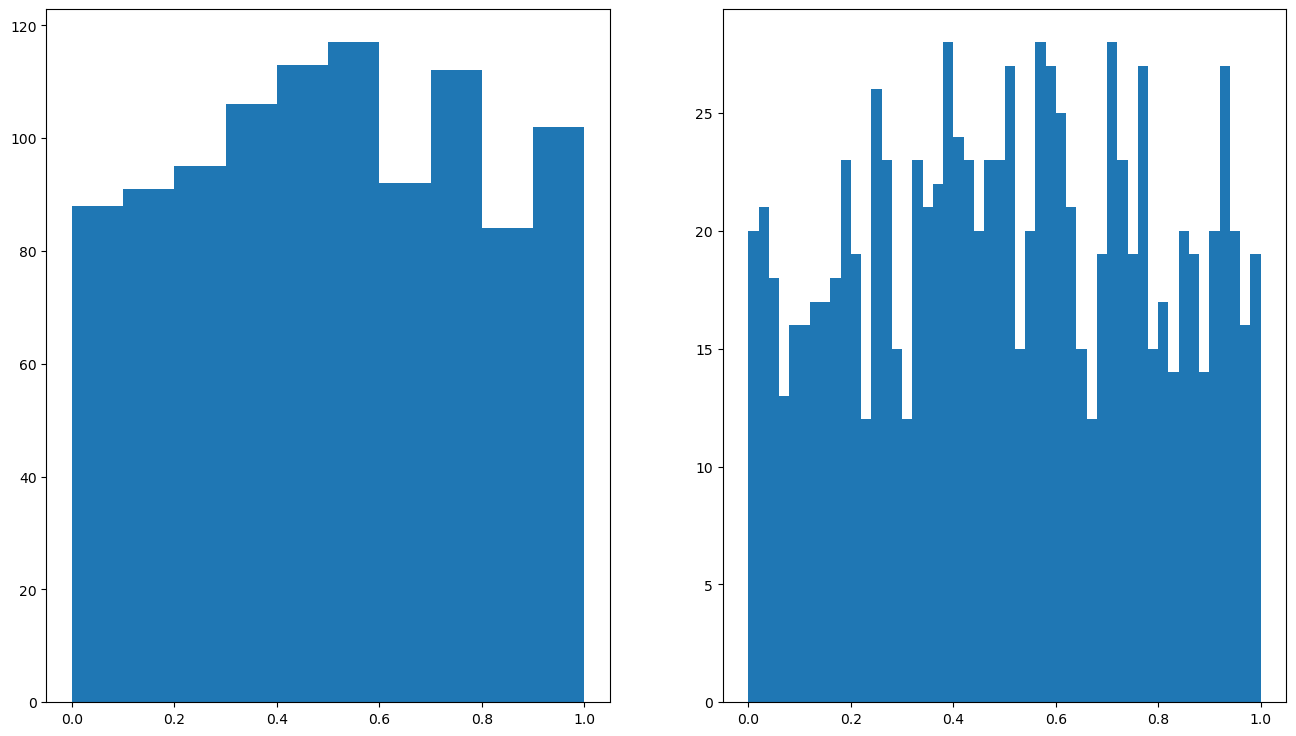

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.hist(t_values, 10)
ax2.hist(t_values, 50);